# High amplitude glitch issue

In [1]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
from ldc.lisa.noise import get_noise_model, AnalyticNoise
from lisainstrument import Instrument
import pytdi
from pytdi.michelson import X2, Y2, Z2, X1, Y1, Z1
from pytdi import Data
import logging
from lisainstrument.containers import ForEachMOSA
from ldc.common.tools import window
import lisaglitch
import os

## Short simulation with this single glitch

ampl: -7.9e-5
beta: 0.0204

In [2]:
logger = logging.getLogger('lisainstrument')
logger.setLevel(logging.INFO)

dt_instru = 0.25
physics_upsampling = 1
dt_physic = dt_instru/physics_upsampling

central_freq = 2.816E14
aafilter = None
            
N = 120960      
        
d = {"backlinknoise":3e-12 , "accnoise": 2.4e-15, "readoutnoise":6.35e-12 }

glitch_file = 'glitch.h5'
os.remove(glitch_file)
g = lisaglitch.ShapeletGlitch(inj_point='tm_12', 
                              t0=0, size=N, dt=dt_instru, t_inj=10000,
                              beta=0.0204, amp=-7.96e-5)
g.write(path=glitch_file)


i = Instrument(physics_upsampling=physics_upsampling, aafilter=aafilter, size=N, 
               dt=dt_instru, central_freq=central_freq, backlink_asds=d["backlinknoise"],
               testmass_asds=d["accnoise"], glitches=glitch_file)
i.oms_isc_carrier_asds = ForEachMOSA(d["readoutnoise"])

i.disable_clock_noises()
i.modulation_asds = ForEachMOSA(0)
i.disable_ranging_noises()
i.laser_asds = ForEachMOSA(0)
i.disable_dopplers()
i.simulate() # Run simulator

data = Data.from_instrument(i)
data.delay_derivative = None

In [3]:
built = X1.build(**data.args_nodoppler)
X2_data = built(data.measurements)/central_freq

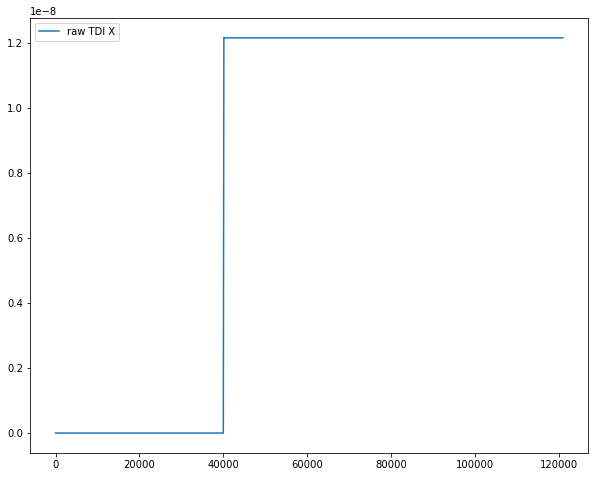

In [4]:
plt.figure(figsize=(10,8))
plt.plot(X2_data, label='raw TDI X')
plt.legend()

## A noise free simulation, with a more standard glitch



In [5]:
glitch_file = 'glitch-2.h5'
os.remove(glitch_file)
g = lisaglitch.ShapeletGlitch(inj_point='tm_12', 
                              t0=0, size=N, dt=dt_instru, t_inj=10000,
                              beta=59.7187, amp=1.5369e-10) 
g.write(path=glitch_file)

i2 = Instrument(physics_upsampling=physics_upsampling, aafilter=aafilter, size=N, 
               dt=dt_instru, central_freq=central_freq, backlink_asds=d["backlinknoise"],
               testmass_asds=d["accnoise"], glitches=glitch_file)
i2.disable_all_noises()
#i2.oms_isc_carrier_asds = ForEachMOSA(d["readoutnoise"])
#i2.disable_clock_noises()
#i2.modulation_asds = ForEachMOSA(0)
#i2.disable_ranging_noises()
#i2.laser_asds = ForEachMOSA(0)
i2.disable_dopplers()

i2.simulate() # Run simulator
data = Data.from_instrument(i2)
data.delay_derivative = None

In [6]:
built = X1.build(**data.args_nodoppler)
X2_data = built(data.measurements)/central_freq

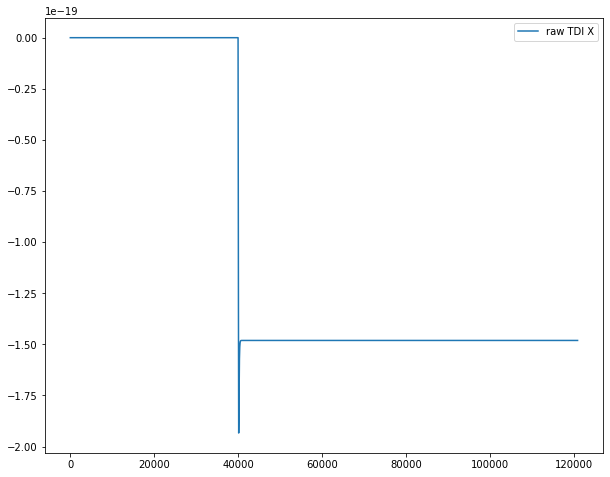

In [7]:
plt.figure(figsize=(10,8))
plt.plot(X2_data, label='raw TDI X')
#plt.axvline(x=40000, color='r')
plt.legend()

It never goes back to 0 ...

## Looking at ampl and beta distribution

In [8]:
beta = np.loadtxt("beta.txt")
ampl = np.loadtxt("ampl.txt")
t_inj = np.loadtxt("tinj.txt")
s = (t_inj>28280500) & (t_inj<28281000)
print(s.sum())

1


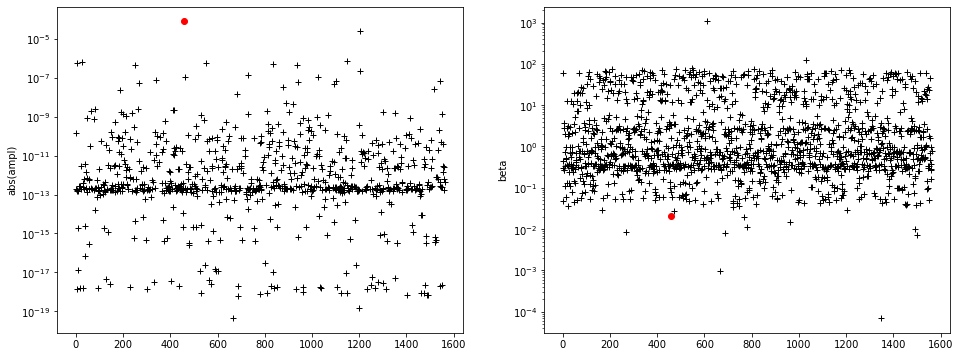

In [9]:
ng = len(ampl)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.ylabel('abs(ampl)')
plt.plot(np.arange(ng), ampl, 'k+')
plt.plot(np.arange(ng)[s], np.abs(ampl[s]), "ro")
plt.yscale('log')
plt.subplot(1,2,2)
plt.ylabel('beta')
plt.plot(np.arange(ng), beta, 'k+')
plt.plot(np.arange(ng)[s], (beta[s]), "ro")
plt.yscale('log')

In [10]:
beta[0]

59.71879577636719

In [11]:
ampl[0]

1.5369042150048529e-10